## **Predictive Analysis Plan for the Titanic Dataset**  

1. Define the Problem Statement
2. Data Preparation for Modeling
3. Model Selection
4. Model Training & Evaluation
5. Hyperparameter Tuning
6. Model Comparison & Selection
7. Final Model & Predictions
8. Model Interpretation & Explainability
9. Deployment (Optional)


### **1. Define the Problem Statement**  
- Goal: Predict passenger survival (`Survived` column) using available features.  
- Type of problem: Binary Classification (0 = Not Survived, 1 = Survived).  

The goal is to build a machine learning model that predicts whether a passenger survived the Titanic disaster based on various features such as age, sex, passenger class, and fare.

* Objective:

Input: Passenger details (e.g., Age, Sex, Pclass, etc.)
Output: Binary prediction — 0 (Did Not Survive) or 1 (Survived)


* Key Challenges to Address

Imbalanced classes (more non-survivors than survivors).
Presence of missing values (e.g., Cabin, Embarked).
Potentially correlated features (e.g., Pclass and Fare).
Non-linear relationships that might require feature engineering.

* Success Criteria (Metrics)

Primary Metric: F1 Score (balances precision & recall).
Secondary Metrics: Accuracy, ROC-AUC score, and Confusion Matrix for detailed insights.

In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as stats

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import time

In [4]:
test_df = pd.read_csv("cleaned_data/cleaned_testing_data.csv")
df = pd.read_csv("cleaned_data/cleaned_training_data.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,F
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,F
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,F


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
 11  Deck         891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### **2. Data Preparation for Modeling**
- **Feature Selection & Engineering**
  - Drop irrelevant features (`PassengerId`, `Name`, `Ticket` as they may not contribute).
  - Encode categorical variables (`Sex`, `Embarked`, `Deck`).
  - Convert `Fare` and `Age` into binned categories (if needed).
  - Create new features (e.g., `FamilySize = SibSp + Parch + 1`).


In [6]:
test_passenger_id = test_df.PassengerId
test_df.drop(['PassengerId', 'Name', 'Ticket',], axis=1, inplace=True)
df.drop(['PassengerId', 'Name', 'Ticket',], axis=1, inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck
0,0,3,male,22.0,1,0,7.2500,S,F
1,1,1,female,38.0,1,0,71.2833,C,C
2,1,3,female,26.0,0,0,7.9250,S,F
3,1,1,female,35.0,1,0,53.1000,S,C
4,0,3,male,35.0,0,0,8.0500,S,F


In [7]:
# label encoding
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])  # female → 0, male → 1
test_df['Sex'] = le.fit_transform(test_df['Sex'])  # female → 0, male → 1

In [8]:
df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck
0,0,3,1,22.0,1,0,7.2500,S,F
1,1,1,0,38.0,1,0,71.2833,C,C
2,1,3,0,26.0,0,0,7.9250,S,F


In [9]:
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck
0,3,1,34.5,0,0,7.8292,Q,F
1,3,0,47.0,1,0,7.0000,S,F
2,2,1,62.0,0,0,9.6875,Q,F
3,3,1,27.0,0,0,8.6625,S,F
4,3,0,22.0,1,1,12.2875,S,F


In [10]:
# one-hot encoding
test_df = pd.get_dummies(test_df, columns=['Embarked'], drop_first=True)
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)
# drop_first reduces multicollinearity by dropping one column from each encoded category.
df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Deck,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,7.2500,F,False,True
1,1,1,0,38.0,1,0,71.2833,C,False,False
2,1,3,0,26.0,0,0,7.9250,F,False,True


Let's check correlation of fare and deck to see if we can group deck values, segregate them into classes.

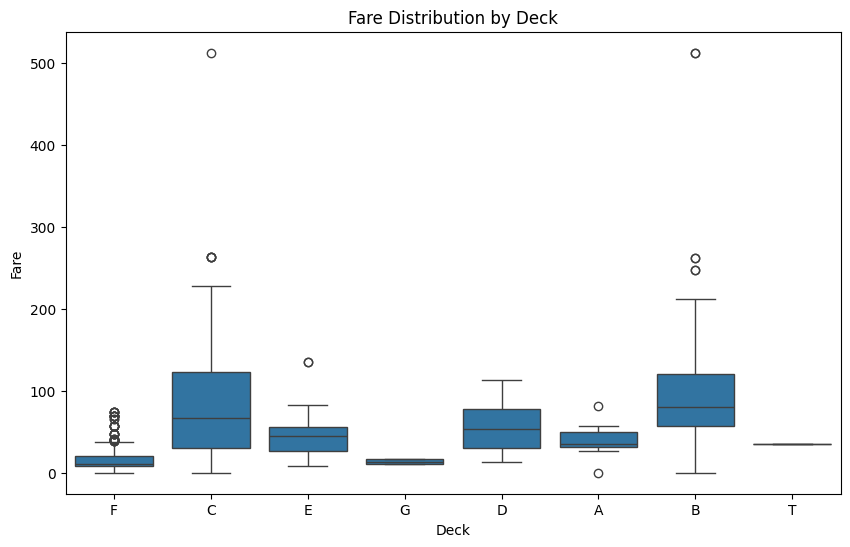

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Deck', y='Fare')
plt.title('Fare Distribution by Deck')
plt.show()

In [12]:
# Create a mapping dictionary
deck_mapping = {
    'B': 2, 'C': 2, 'D': 2,  # High-Class → 2
    'E': 1, 'A': 1,          # Mid-Class → 1
    'F': 0, 'G': 0, 'T': 0   # Low-Class → 0
}

# Map the Deck column to the new categories
df['Deck_Class'] = df['Deck'].map(deck_mapping)
test_df['Deck_Class'] = test_df['Deck'].map(deck_mapping)

# Display the updated dataframe
print(df[['Deck', 'Deck_Class']].head(10))

  Deck  Deck_Class
0    F           0
1    C           2
2    F           0
3    C           2
4    F           0
5    F           0
6    E           1
7    F           0
8    F           0
9    F           0


In [13]:
test_df.drop('Deck', inplace=True, axis=1)
df.drop('Deck', inplace=True, axis=1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,Deck_Class
0,0,3,1,22.0,1,0,7.2500,False,True,0
1,1,1,0,38.0,1,0,71.2833,False,False,2
2,1,3,0,26.0,0,0,7.9250,False,True,0
3,1,1,0,35.0,1,0,53.1000,False,True,2
4,0,3,1,35.0,0,0,8.0500,False,True,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int32  
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Embarked_Q  891 non-null    bool   
 8   Embarked_S  891 non-null    bool   
 9   Deck_Class  891 non-null    int64  
dtypes: bool(2), float64(2), int32(1), int64(5)
memory usage: 54.1 KB


Binning age and fare

In [15]:
fare_bins = [0, 10, 50, df['Fare'].max()]
fare_labels = [0, 1, 2]  # Low, Medium, High
test_df['Fare_Bin'] = pd.cut(test_df['Fare'], bins=fare_bins, labels=fare_labels, include_lowest=True)
df['Fare_Bin'] = pd.cut(df['Fare'], bins=fare_bins, labels=fare_labels, include_lowest=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,Deck_Class,Fare_Bin
0,0,3,1,22.0,1,0,7.2500,False,True,0,0
1,1,1,0,38.0,1,0,71.2833,False,False,2,2
2,1,3,0,26.0,0,0,7.9250,False,True,0,0
3,1,1,0,35.0,1,0,53.1000,False,True,2,2
4,0,3,1,35.0,0,0,8.0500,False,True,0,0


In [16]:
age_bins = [0, 12, 19, 59, df['Age'].max()]
age_labels = [0, 1, 2, 3]  # Child, Teen, Adult, Senior
test_df['Age_Bin'] = pd.cut(test_df['Age'], bins=age_bins, labels=age_labels)
df['Age_Bin'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,Deck_Class,Fare_Bin,Age_Bin
0,0,3,1,22.0,1,0,7.2500,False,True,0,0,2
1,1,1,0,38.0,1,0,71.2833,False,False,2,2,2
2,1,3,0,26.0,0,0,7.9250,False,True,0,0,2
3,1,1,0,35.0,1,0,53.1000,False,True,2,2,2
4,0,3,1,35.0,0,0,8.0500,False,True,0,0,2


In [17]:
df.Fare_Bin.value_counts()

Fare_Bin
1    395
0    336
2    160
Name: count, dtype: int64

In [18]:
test_df.drop(['Age', 'Fare'], inplace=True, axis=1)
df.drop(['Age', 'Fare'], inplace=True, axis=1)
df.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked_Q,Embarked_S,Deck_Class,Fare_Bin,Age_Bin
0,0,3,1,1,0,False,True,0,0,2
1,1,1,0,1,0,False,False,2,2,2
2,1,3,0,0,0,False,True,0,0,2
3,1,1,0,1,0,False,True,2,2,2
4,0,3,1,0,0,False,True,0,0,2


Some feature engineering on SubSp and Parch

In [19]:
df['Family_Size'] = df['SibSp'] + df['Parch'] + 1  # Add 1 to include the passenger themselves
test_df['Family_Size'] = test_df['SibSp'] + test_df['Parch'] + 1

# and, we categorize this family size 
df['Family_Group'] = pd.cut(df['Family_Size'], 
                            bins=[0, 1, 4, 7, df['Family_Size'].max()],
                            labels=[0, 1, 2, 3])  # Solo, Small, Medium, Large

test_df['Family_Group'] = pd.cut(test_df['Family_Size'], 
                            bins=[0, 1, 4, 7, test_df['Family_Size'].max()],
                            labels=[0, 1, 2, 3])  # Solo, Small, Medium, Large


test_df.drop(['SibSp', 'Parch', 'Family_Size'], inplace=True, axis=1)
df.drop(['SibSp', 'Parch', 'Family_Size'], inplace=True, axis=1)
df.head()

,Survived,Pclass,Sex,Embarked_Q,Embarked_S,Deck_Class,Fare_Bin,Age_Bin,Family_Group
0,0,3,1,False,True,0,0,2,1
1,1,1,0,False,False,2,2,2,1
2,1,3,0,False,True,0,0,2,0
3,1,1,0,False,True,2,2,2,1
4,0,3,1,False,True,0,0,2,0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Survived      891 non-null    int64   
 1   Pclass        891 non-null    int64   
 2   Sex           891 non-null    int32   
 3   Embarked_Q    891 non-null    bool    
 4   Embarked_S    891 non-null    bool    
 5   Deck_Class    891 non-null    int64   
 6   Fare_Bin      891 non-null    category
 7   Age_Bin       891 non-null    category
 8   Family_Group  891 non-null    category
dtypes: bool(2), category(3), int32(1), int64(3)
memory usage: 29.4 KB


In [21]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Pclass        418 non-null    int64   
 1   Sex           418 non-null    int32   
 2   Embarked_Q    418 non-null    bool    
 3   Embarked_S    418 non-null    bool    
 4   Deck_Class    418 non-null    int64   
 5   Fare_Bin      418 non-null    category
 6   Age_Bin       418 non-null    category
 7   Family_Group  418 non-null    category
dtypes: bool(2), category(3), int32(1), int64(2)
memory usage: 10.9 KB


### **Splitting Data**  
  - Use `train_test_split()` to create training (80%) and testing (20%) datasets.  
  - Consider stratified sampling to maintain class distribution balance.  


In [22]:
X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# stratify=y : Ensures both train and test sets have similar proportions of survivors and non-survivors. 
# This is crucial since the Titanic dataset has an imbalanced class distribution.

In [23]:
print(X_train.shape, X_test.shape)
print(y_train.value_counts(normalize=True))  # Confirm class balance
print(y_test.value_counts(normalize=True))

# we use 'normalize' to get values as ratio(s)

(712, 8) (179, 8)
Survived
0    0.616573
1    0.383427
Name: proportion, dtype: float64
Survived
0    0.614525
1    0.385475
Name: proportion, dtype: float64


### **Feature Scaling**  
  - Standardize numerical features (`Age`, `Fare`) using `StandardScaler()`.  

In [24]:
# scaling is not required. the columns were binned.

### **3. Model Selection**  
- Try multiple algorithms:  
  - **Baseline Model**: Logistic Regression  
  - **Tree-Based Models**: Decision Tree, Random Forest, XGBoost  
  - **Ensemble Methods**: Gradient Boosting, AdaBoost  
  - **Advanced Models**: Support Vector Machine (SVM), Neural Networks (optional)  

We'll start with models that handle categorical data really well. Then, we'll move to linear models.

1. Decision Tree
2. Random Forest
3. CatBoost
4. LightGBM
5. XGBoost (with enable_categorical=True)
5. HistGradientBoostingClassifier (from sklearn with native categorical support)

### **4. Model Training & Evaluation**  
- **Train models** on the training dataset.  
- **Evaluate performance** using:  
  - Accuracy, Precision, Recall, F1-score, ROC-AUC curve  
  - Confusion Matrix for classification errors  
  - Feature Importance (for tree-based models) 

In [25]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)

# Performance Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8212290502793296
              precision    recall  f1-score   support

           0       0.81      0.93      0.86       110
           1       0.85      0.65      0.74        69

    accuracy                           0.82       179
   macro avg       0.83      0.79      0.80       179
weighted avg       0.82      0.82      0.82       179



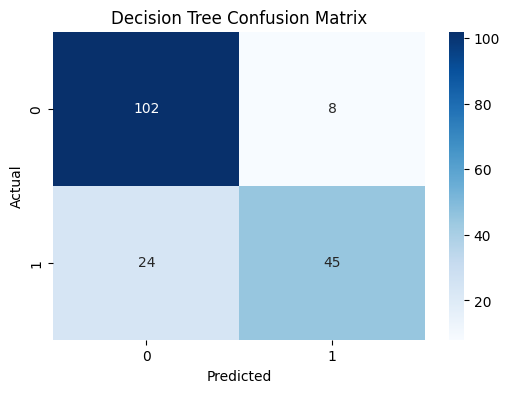

In [26]:
# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Confusion Matrix')
plt.show()

### **5. Hyperparameter Tuning**  
- Use **GridSearchCV** or **RandomizedSearchCV** to optimize models.  

In [27]:
# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize model
dt_model = DecisionTreeClassifier(random_state=42)

# GridSearchCV setup
grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best Score: 0.8315079286910272


Tuned Model Accuracy: 0.8044692737430168
              precision    recall  f1-score   support

           0       0.80      0.92      0.85       110
           1       0.83      0.62      0.71        69

    accuracy                           0.80       179
   macro avg       0.81      0.77      0.78       179
weighted avg       0.81      0.80      0.80       179



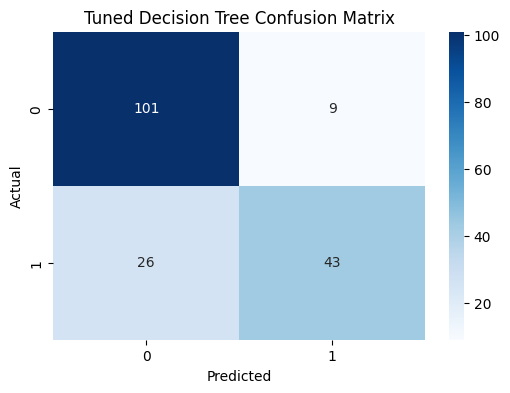

In [28]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Updated Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Tuned Decision Tree Confusion Matrix')
plt.show()

### **6. Model Comparison & Selection**  
- Compare models and select the best-performing one based on metrics.  

In [29]:
# Sample results DataFrame
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC-ROC', 'Training Time', 'Hyperparameters'])

# Example function to log results
def log_results(model, model_name, X_train, X_test, y_train, y_test, params=None):
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    train_time = round(time.time() - start_time, 2)
    results.loc[len(results)] = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_pred),
        'Training Time': train_time,
        'Hyperparameters': params
    }

In [30]:
# Models with relevant parameters

log_results(DecisionTreeClassifier(max_depth=5), "Decision Tree", X_train, X_test, y_train, y_test, {'max_depth': 5})

log_results(RandomForestClassifier(n_estimators=200, max_depth=7), "Random Forest", X_train, X_test, y_train, y_test, {'n_estimators': 200, 'max_depth': 7})

log_results(CatBoostClassifier(iterations=200, depth=6, learning_rate=0.1, verbose=0, cat_features=['Fare_Bin', 'Age_Bin', 'Family_Group']), "CatBoost", X_train, X_test, y_train, y_test, {'iterations': 200, 'depth': 6, 'learning_rate': 0.1})

log_results(LogisticRegression(solver='lbfgs', max_iter=500), "Logistic Regression", X_train, X_test, y_train, y_test, {'solver': 'lbfgs', 'max_iter': 500})

log_results(GaussianNB(), "Naive Bayes", X_train, X_test, y_train, y_test)

log_results(KNeighborsClassifier(n_neighbors=5), "K-Nearest Neighbors", X_train, X_test, y_train, y_test, {'n_neighbors': 5})

log_results(SVC(kernel='rbf', C=1.0, probability=True), "Support Vector Machine", X_train, X_test, y_train, y_test, {'kernel': 'rbf', 'C': 1.0})

log_results(HistGradientBoostingClassifier(max_iter=200), "HistGradientBoosting", X_train, X_test, y_train, y_test, {'max_iter': 200})


In [31]:
results

,Model,Accuracy,Precision,Recall,F1,AUC-ROC,Training Time,Hyperparameters
0,Decision Tree,0.804469,0.826923,0.623188,0.710744,0.770685,0.00,{'max_depth': 5}
1,Random Forest,0.810056,0.843137,0.623188,0.716667,0.775231,0.26,"{'n_estimators': 200, 'max_depth': 7}"
2,CatBoost,0.804469,0.840000,0.608696,0.705882,0.767984,5.45,"{'iterations': 200, 'depth': 6, 'learning_rate..."
3,Logistic Regression,0.754190,0.719298,0.594203,0.650794,0.724374,0.01,"{'solver': 'lbfgs', 'max_iter': 500}"
4,Naive Bayes,0.737430,0.634146,0.753623,0.688742,0.740448,0.00,None
5,K-Nearest Neighbors,0.787709,0.738462,0.695652,0.716418,0.770553,0.01,{'n_neighbors': 5}
6,Support Vector Machine,0.810056,0.796610,0.681159,0.734375,0.786034,0.05,"{'kernel': 'rbf', 'C': 1.0}"
7,HistGradientBoosting,0.810056,0.830189,0.637681,0.721311,0.777931,0.38,{'max_iter': 200}


### 7. Final Model & Predictions**  
- Train the selected model on the full dataset.  
- Generate predictions on the test dataset. 

In [32]:
train_df = df

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Survived      891 non-null    int64   
 1   Pclass        891 non-null    int64   
 2   Sex           891 non-null    int32   
 3   Embarked_Q    891 non-null    bool    
 4   Embarked_S    891 non-null    bool    
 5   Deck_Class    891 non-null    int64   
 6   Fare_Bin      891 non-null    category
 7   Age_Bin       891 non-null    category
 8   Family_Group  891 non-null    category
dtypes: bool(2), category(3), int32(1), int64(3)
memory usage: 29.4 KB


In [34]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Pclass        418 non-null    int64   
 1   Sex           418 non-null    int32   
 2   Embarked_Q    418 non-null    bool    
 3   Embarked_S    418 non-null    bool    
 4   Deck_Class    418 non-null    int64   
 5   Fare_Bin      418 non-null    category
 6   Age_Bin       418 non-null    category
 7   Family_Group  418 non-null    category
dtypes: bool(2), category(3), int32(1), int64(2)
memory usage: 10.9 KB


In [35]:
X_train = train_df.drop(['Survived'], axis=1)
y_train = train_df['Survived']

X_test = test_df

In [36]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)

(891, 8)
(891,)
(418, 8)


In [37]:
model = RandomForestClassifier(n_estimators=200, max_depth=5) # test with 5 too

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [38]:
print(y_pred.shape)

(418,)


In [39]:
type(y_pred)

numpy.ndarray

In [40]:
submission_df = pd.DataFrame({
    'PassengerId': test_passenger_id,
    'Survived': y_pred.astype(int)  # Ensure it's integer (0 or 1)
})

submission_df.to_csv("final_predictions2.csv", index=False)

In [41]:
model = RandomForestClassifier(n_estimators=200, max_depth=5) # test with 5 too

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("y_pred.shape: ", y_pred.shape)

submission_df = pd.DataFrame({
    'PassengerId': test_passenger_id,
    'Survived': y_pred.astype(int)  # Ensure it's integer (0 or 1)
})

submission_df.to_csv("final_predictions3.csv", index=False)

y_pred.shape:  (418,)
